<b><font size="5">Predicting the Difficulty and Enjoyment Rating of Hiking Trails</font></b>

Here, I build models to predict the difficulty and enjoyment rating of trails I am personally interested in hiking. Thanks to Jane for the base dataset of ~3000 trails in USA national parks (https://www.kaggle.com/datasets/planejane/national-park-trails). This data was scraped from AllTrails. Attempts to scrape AllTrails data myself were blocked by bot-detection.

Jane's dataset includes columns for trail length, elevation gain, park, state/province, country, route type, latitude, longitude, number of reviews, difficulty, and enjoyment rating. After some manipulation of the dataset, I add columns for whether the trails include a forest, lake, river, waterfall, beach, historic site, cave, hot spring, and/or backpacking trail.

In addition to this dataset, I include data from trails I've hiked myself. I add a column to keep track of which trails are mine, which helps fine-tune the model to my preferences. A historical weather API is used to get climate data for each trail location. Data for summer temperature, winter tempurate, and annual rain is obtained this way. For trails I have completed, I get maximum temperature, minimum temperature, and total amount of rain as well.

It would be better to have a dataset of individual trail reviews linked to a single user profiles.

<b>Summary of Steps:</b>
1. Get climate data for each trail location using HistoricalWeatherFinder.ipynb
1. Format and combine my dataset with the Jane's dataset
1. Generate statics and visualizations
1. Generate difficulty models and predictions
1. Generate rating model and predictions
1. Visualize prediction results in a single plot

<b>Summary of Results:</b>
- Difficulty Model Score: 0.705
- Rating Model Score: 0.222

Turns out that a trail's length, elevation gain, climate, and physical features are enough to predict its difficulty with decent accuracy. Enjoyment is a different matter. Enjoyment is impacted greatly by season, weather, preparedness, and who you are hiking with, none of which is accounted for.

<b><font size="3">--- Imports and Defining Variables ---</font></b>

In [1]:
### Imports

import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import pickle
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import plotly.graph_objs as go
import requests
import matplotlib.dates as mdates
import plotly.express as px
import datetime as dt
pd.options.mode.chained_assignment = None

In [2]:
### Defining Variables

# colours
diffColors = np.array(['limegreen', 'yellow', 'darkorange', 'red'])
backgroundColor = '#444444'
distColor = 'darkorange'
gainColor = 'deepskyblue'
nightColor = 'violet'
trailsColor = 'tab:red'
legendColor = 'w'

# font sizes
titleSize = 36
axisLabelSize = 27
tickLabelSize = 18
legendTextSize = 18

# misc
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
standardCanvasHeight = 10
standardCanvasWidth = 20
myTrailsCSV = 'MyTrails.csv'

<b><font size="3">Importing and Setting Up Data</font></b>

In [4]:
### Setting Up Dataframes

# importing my trails
myTrails = pd.read_csv(myTrailsCSV, engine='python')

# adding/modifying columns
myTrails['backpacking'] = 1 # I only keep track of backpacking trails
myTrails['is_jamie'] = 1
myTrails['num_reviews'] = 1
myTrails.start_date = pd.to_datetime(myTrails.start_date)
myTrails.end_date = pd.to_datetime(myTrails.end_date)
myTrails['month'] = myTrails.end_date.dt.month

myCompletedTrails = myTrails[myTrails.status == 0] # trails I have completed
myWatchedTrails = myTrails[myTrails.status != 0] # trails on my watchlist

# importing USA National Park data
usaTrails = pd.read_csv('AllTrailsUsaNationalParks.csv', engine='python')

# adding/modifying columns
usaTrails['lat'] = usaTrails.apply(lambda row: row._geoloc.split(': ', 2)[1][:-7], axis=1)
usaTrails['lng'] = usaTrails.apply(lambda row: row._geoloc.split(': ', 2)[2][:-1], axis=1)
usaTrails['forest'] = usaTrails.apply(lambda row: int('forest' in row.features), axis=1)
usaTrails['lake'] = usaTrails.apply(lambda row: int('lake' in row.features), axis=1)
usaTrails['river'] = usaTrails.apply(lambda row: int('river' in row.features), axis=1)
usaTrails['waterfall'] = usaTrails.apply(lambda row: int('waterfall' in row.features), axis=1)
usaTrails['beach'] = usaTrails.apply(lambda row: int('beach' in row.features), axis=1)
usaTrails['historic_site'] = usaTrails.apply(lambda row: int('historic-site' in row.features), axis=1)
usaTrails['cave'] = usaTrails.apply(lambda row: int('cave' in row.features), axis=1)
usaTrails['hot_spring'] = usaTrails.apply(lambda row: int('hot-springs' in row.features), axis=1)
usaTrails['backpacking'] = usaTrails.apply(lambda row: int('backpacking' in row.activities), axis=1)
usaTrails['country_name'] = 'USA'
usaTrails.loc[usaTrails['state_name'] == "Maui", 'state_name'] = "Hawaii"
usaTrails['length'] = usaTrails['length'].apply(lambda row: row/1000) # m to km
usaTrails['is_jamie'] = 0

# filtering
usaTrails = usaTrails[~usaTrails.activities.str.contains('driving')] # removing "Driving" trails
usaTrails = usaTrails[~usaTrails.name.str.contains('Paddle')] # removing "Paddle" trails
usaTrails = usaTrails[usaTrails.elevation_gain >= 10]
usaTrails = usaTrails[usaTrails.length >= 0.5]
usaTrails = usaTrails[usaTrails.num_reviews > 0] # how do some trails have a rating but no reviews?

# removing unneeded columns
usaTrails = usaTrails.drop(['trail_id','city_name','popularity','visitor_usage','units',
                            '_geoloc','features','activities'],axis=1)

# renaming columns
usaTrails = usaTrails.rename(columns={'length': 'distance',
                                      'difficulty_rating':'difficulty',
                                      'avg_rating':'rating',
                                      'area_name':'park',
                                      'state_name':'province',
                                      'country_name':'country'})

ourTrails = pd.concat([usaTrails, myCompletedTrails])
allOurTrails = pd.concat([usaTrails, myTrails])

# catagorical column encoding
one_hot = OneHotEncoder(categories=[allOurTrails.route_type.unique(),
                                    allOurTrails.park.unique(),
                                    allOurTrails.province.unique(),
                                    allOurTrails.country.unique()])
transformer = ColumnTransformer([('one_hot', one_hot, ['route_type','park','province','country'])],
                                remainder='passthrough')

<b><font size="3">Statistics</font></b>

In [10]:
### Statistics

# determines if there is a tie for a trail record
# constructs string for printing
def tieValidator(record, fullLocation=True):
    recordValues = record.name.values
    if len(recordValues) == 1:
        if fullLocation == False:
            return recordValues[0]
        else:
            return f"{record.name.values[0]}, {record.park.values[0]}, {record.province.values[0]}, {record.country.values[0]}"
    else:
        return f"{len(recordValues)} way tie" 

# determines the min/max of a trail feature
# findMax=True -> find the max, findMax=False -> find the min
# perDay=True -> determines the min/max PER DAY
def printTrailRecord(trails, recordName, column, units, findMax=True, perDay=False):
    if perDay == False:
        if findMax == True:
            recordTrails = trails[trails[column] == trails[column].max()]
        else:
            recordTrails = trails[trails[column] == trails[column].min()]  
        return print(f"{recordName}: {round(recordTrails[column].values[0], 1)} {units} ({tieValidator(recordTrails)})")
    else:
        if findMax == True:
            recordTrails = trails[trails[column]/(trails.nights+1) == (trails[column]/(trails.nights+1)).max()]
        else:
            recordTrails = trails[trails[column]/(trails.nights+1) == (trails[column]/(trails.nights+1)).min()]        
        return print(f"{recordName}: {round(recordTrails[column].values[0]/(recordTrails.nights.values[0]+1), 1)} {units}/day ({tieValidator(recordTrails)})")
        
print("FULL DATASET STATISTICS")
print('\n')

print("TOTALS")
numTrails = len(ourTrails)
print(f"Number of Trails: {numTrails}")
print('\n')

print("RECORDS")
printTrailRecord(ourTrails, 'Longest Trail', 'distance', 'km')
steepestTrails = ourTrails[ourTrails.elevation_gain/ourTrails.distance == (ourTrails.elevation_gain/ourTrails.distance).max()]        
print(f"Steepest Trail: {round(steepestTrails.elevation_gain.values[0]/steepestTrails.distance.values[0]/1000, 3)} ({tieValidator(steepestTrails)})")
printTrailRecord(ourTrails, 'Hottest Trail', 'summer_temp', '°C')
printTrailRecord(ourTrails, 'Coldest Trail', 'winter_temp', '°C', findMax=False)
printTrailRecord(ourTrails, 'Wettest Trail', 'annual_rain', 'mm')
printTrailRecord(ourTrails, 'Driest Trail', 'annual_rain', 'mm', findMax=False)
printTrailRecord(ourTrails, 'Trendiest Trail', 'num_reviews', 'reviews')
stateWithMostTrails = ourTrails.province.mode()[0]
print(f"State with Most Trails: {stateWithMostTrails} ({round(len(ourTrails[ourTrails.province == stateWithMostTrails])/numTrails, 3)} of trails)")
print('\n')

print("RATES")
print(f"Backpacking Trail Rate: {round(ourTrails.backpacking.mean(), 2)}")
print(f"Jamie Trail Rate: {round(ourTrails.is_jamie.mean(), 3)}")
print('\n')

print("AVERAGES (BY TRAIL)")
print(f"Average Distance: {round(ourTrails.distance.mean(), 1)} km")
print(f"Average Elevation Gain: {round(ourTrails.elevation_gain.mean())} m")
print('\n')

print("------------------------------------------------------------")
print('\n')

print("MY COMPLETED TRAIL STATISTICS")
print('\n')

print("TOTALS")
totalDist = myCompletedTrails.distance.sum()
print(f"Distance: {round(totalDist, 0)} km ({round(totalDist/40075, 3)} Earth circumnavigations, {round(totalDist/42.195, 1)} marathons, {round(totalDist/0.0299)} blue whales)")
totalGain = myCompletedTrails.elevation_gain.sum()
print(f"Elevation Gain: {totalGain} m ({round(totalGain/(8849-2840), 2)} Everests, {round(totalGain/830, 1)} Burj Khalifas, {round(totalGain/1.8415)} Jamies)")
numCompletedTrails = len(myCompletedTrails)
print(f"Number of Trails: {numCompletedTrails}")
print(f"Number of Nights: {round(myCompletedTrails.nights.sum())}")
totalRain = myCompletedTrails.rain.sum()
print(f"Rain: {round(totalRain)} mm ({round(totalRain/190.5,1)} bananas)")
print('\n')

print("RECORDS")
printTrailRecord(myCompletedTrails, 'Most Distance', 'distance', 'km')
printTrailRecord(myCompletedTrails, 'Most Elevation Gain', 'elevation_gain', 'm')
printTrailRecord(myCompletedTrails, 'Most Distance per Day', 'distance', 'km', perDay=True)
printTrailRecord(myCompletedTrails, 'Most Elevation Gain per Day', 'elevation_gain', 'm', perDay=True)
printTrailRecord(myCompletedTrails, 'Most Nights', 'nights', 'nights')
printTrailRecord(myCompletedTrails, 'Hottest Temperature', 'max_temp', '°C')
printTrailRecord(myCompletedTrails, 'Coldest Temperature', 'min_temp', '°C', findMax=False)
printTrailRecord(myCompletedTrails, 'Most Rain', 'rain', 'mm')
print(f"Most Common Park: {myCompletedTrails.park.mode().iloc[0]} ({round(myCompletedTrails.park.value_counts()[0]/numCompletedTrails, 2)} of trails)")
print('\n')

print("RATES")
print(f"Solo Rate: {round(len(myCompletedTrails[myCompletedTrails.people == 1])/numCompletedTrails, 2)}")
print(f"Forest Rate: {round(myCompletedTrails.forest.mean(), 2)}")
print(f"Lake Rate: {round(myCompletedTrails.lake.mean(), 2)}")
print(f"River Rate: {round(myCompletedTrails.river.mean(), 2)}")
print(f"Waterfall Rate: {round(myCompletedTrails.waterfall.mean(), 2)}")
print(f"Beach Rate: {round(myCompletedTrails.beach.mean(), 2)}")
print(f"Historic Site Rate: {round(myCompletedTrails.historic_site.mean(), 2)}")
print(f"Cave Rate: {round(myCompletedTrails.cave.mean(), 2)}")
print(f"Hot Spring Rate: {round(myCompletedTrails.hot_spring.mean(), 2)}")
print('\n')

print("AVERAGES (BY TRAIL)")
print(f"Average Distance: {round(myCompletedTrails.distance.mean(), 1)} km")
print(f"Average Elevation Gain: {round(myCompletedTrails.elevation_gain.mean())} m")
print(f"Average Nights: {round(myCompletedTrails.nights.mean(), 1)} nights")
print('\n')

print("AVERAGES (BY DAY)")
mySoloTrails = myCompletedTrails[myCompletedTrails.people == 1]
myGroupTrails = myCompletedTrails[myCompletedTrails.people > 1]
print(f"Average Distance: {round(myCompletedTrails.distance.sum()/(myCompletedTrails.nights.sum()+numCompletedTrails), 1)} km " 
      + f"(Solo: {round(mySoloTrails.distance.sum()/(mySoloTrails.nights.sum()+len(mySoloTrails)), 1)} km, " 
      + f"Group: {round(myGroupTrails.distance.sum()/(myGroupTrails.nights.sum()+len(myGroupTrails)), 1)} km)")
print(f"Average Elevation Gain: {round(myCompletedTrails.elevation_gain.sum()/(myCompletedTrails.nights.sum()+numCompletedTrails))} m " 
      + f"(Solo: {round(mySoloTrails.elevation_gain.sum()/(mySoloTrails.nights.sum()+len(mySoloTrails)))} m, " 
      + f"Group: {round(myGroupTrails.elevation_gain.sum()/(myGroupTrails.nights.sum()+len(myGroupTrails)))} m)")


FULL DATASET STATISTICS


TOTALS
Number of Trails: 2911


RECORDS
Longest Trail: 326.9 km (John Muir Trail via Yosemite Valley, Yosemite National Park, California, USA)
Steepest Trail: 0.26 (Tomichi Trail, Black Canyon of the Gunnison National Park, Colorado, USA)
Hottest Trail: 49.2 °C (Helios Canyon, Death Valley National Park, California, USA)
Coldest Trail: -35.1 °C (Stampede Trail to Sushana River, Denali National Park, Alaska, USA)
Wettest Trail: 3677.2 mm (Palm Trail, Hawaii Volcanoes National Park, Hawaii, USA)
Driest Trail: 65.7 mm (Corkscrew Peak, Death Valley National Park, California, USA)
Trendiest Trail: 3903 reviews (Angels Landing Trail, Zion National Park, Utah, USA)
State with Most Trails: California (0.204 of trails)


RATES
Backpacking Trail Rate: 0.28
Jamie Trail Rate: 0.006


AVERAGES (BY TRAIL)
Average Distance: 16.0 km
Average Elevation Gain: 638 m


------------------------------------------------------------


MY COMPLETED TRAIL STATISTICS


TOTALS
Distance: 4

<b><font size="3">Data Visulaizations</font></b>

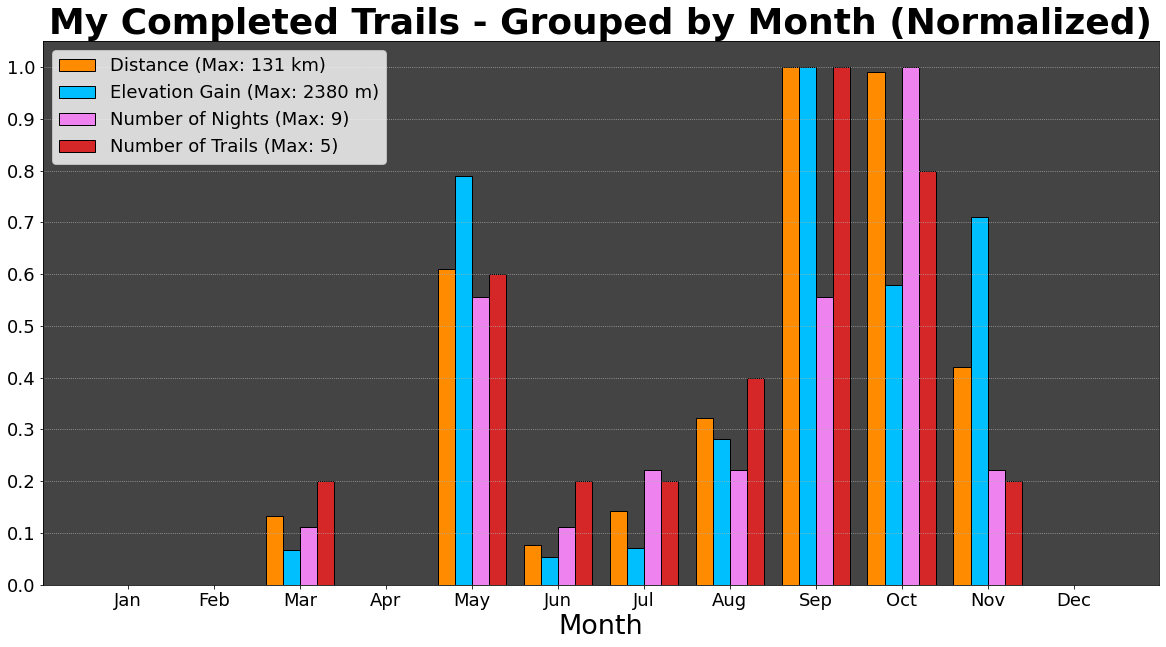

In [12]:
### My Completed Trails - Grouped by Month

# to be filled iteratively
monthDists = np.zeros(12)
monthGains = np.zeros(12)
monthNights = np.zeros(12)
monthTrails = np.zeros(12)

def addHikeToMonth(trail):
    month = int(trail.month-1)
    monthDists[month] += trail.distance
    monthGains[month] += trail.elevation_gain
    monthNights[month] += trail.nights
    monthTrails[month] += 1
    
myCompletedTrails.apply(addHikeToMonth, axis=1)
        
# normalizing
monthDistsN = monthDists/np.max(monthDists)
monthGainsN = monthGains/np.max(monthGains)
monthNightsN = monthNights/np.max(monthNights)
monthTrailsN = monthTrails/np.max(monthTrails)

# plotting
ax = plt.gca()
fig = plt.gcf()
ax.set_title("My Completed Trails - Grouped by Month (Normalized)", size=titleSize, fontweight='bold')
xAxis = np.arange(len(months))
plt.bar(xAxis-0.3, monthDistsN, 0.2, label=f"Distance (Max: {round(monthDists.max())} km)", 
        color=distColor, edgecolor='k')
plt.bar(xAxis-0.1, monthGainsN, 0.2, label=f"Elevation Gain (Max: {round(monthGains.max())} m)", 
        color=gainColor, edgecolor='k')
plt.bar(xAxis+0.1, monthNightsN, 0.2, label=f"Number of Nights (Max: {round(monthNights.max())})", 
        color=nightColor, edgecolor='k')
plt.bar(xAxis+0.3, monthTrailsN, 0.2, label=f"Number of Trails (Max: {round(monthTrails.max())})", 
        color=trailsColor, edgecolor='k')
plt.legend(loc=2, facecolor=legendColor, prop={'size': legendTextSize})
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.xlabel("Month", size=axisLabelSize)
plt.rcParams['axes.facecolor'] = backgroundColor
plt.xticks(xAxis, months)
ax.tick_params(axis='y', which='both', labelsize=tickLabelSize)
ax.tick_params(axis='x', which='both', labelsize=tickLabelSize)
plt.locator_params(axis='y', nbins=11)
plt.grid(axis='y', which='both', linestyle= 'dotted')
plt.grid(axis='x', which='both', linestyle= 'none')
plt.show()

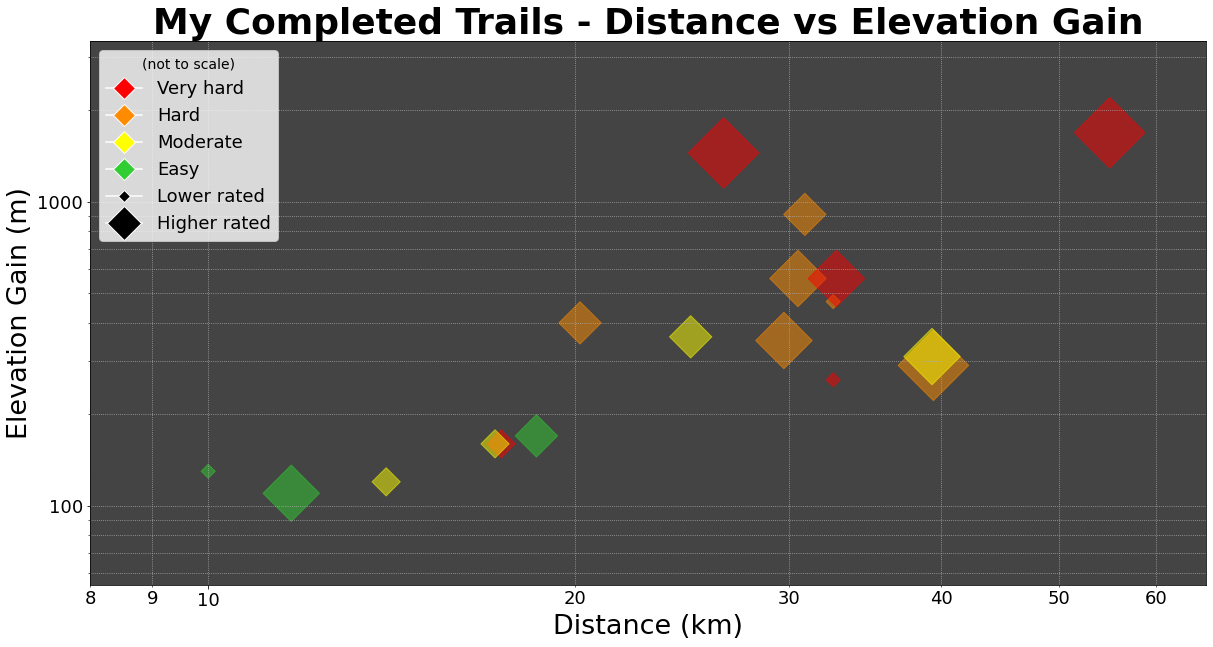

In [13]:
### My Completed Trails - Distance vs Elevation Gain (with Difficulty, and Rating)

# generates a plot of Distance vs Elevation Gain (with Difficulty, and Rating)
def distGainPlot(titleStart, dist, gain, rating, difficulty):
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"{titleStart} - Distance vs Elevation Gain", size=titleSize, fontweight="bold")
    
    legend_elements = [
        Line2D([0], [0], marker='D', c=legendColor, label="Very hard", markerfacecolor=diffColors[3], markersize=15),
        Line2D([0], [0], marker='D', c=legendColor, label="Hard", markerfacecolor=diffColors[2], markersize=15),
        Line2D([0], [0], marker='D', c=legendColor, label="Moderate", markerfacecolor=diffColors[1], markersize=15),
        Line2D([0], [0], marker='D', c=legendColor, label="Easy", markerfacecolor=diffColors[0], markersize=15),
        Line2D([0], [0], marker='D', c=legendColor, label="Lower rated", markerfacecolor='k', markersize=8),
        Line2D([0], [0], marker='D', c=legendColor, label="Higher rated", markerfacecolor='k', markersize=24)
    ]
    
    ax.legend(handles=legend_elements, facecolor=legendColor, prop={'size': legendTextSize}, loc=2,
              title='(not to scale)', title_fontsize=14)
    plt.scatter(dist, gain, s=rating, c=diffColors[difficulty], marker='D', alpha=0.5)
    fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
    plt.rcParams['axes.facecolor'] = backgroundColor
    ax.set_ylim(min(gain)*0.5, max(gain)*2)
    ax.set_xlim(min(dist)*0.8, max(dist)*1.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlabel("Distance (km)", size=axisLabelSize)
    plt.ylabel("Elevation Gain (m)", size=axisLabelSize)
    plt.grid(axis="both", which="both", linestyle= 'dotted')
    ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    plt.show()

# sets datapoint size based on rating
# don't ask, or even better, don't look
def ratingSize(rating):
    return (rating)**2*100

# converts difficulty to its corresponding index in diffColors
def difficultyColourIndex(trails):
    difficulties = []
    for i, trail in trails.iterrows():
        if trail.difficulty == 1:
            difficulties.append(0)
        elif trail.difficulty == 3:
            difficulties.append(1)
        elif trail.difficulty == 5:
            difficulties.append(2)
        elif trail.difficulty == 7:
            difficulties.append(3)
    return difficulties

# generating Distance vs Elevation Gain plot for my completed trails
distCompleted = myCompletedTrails.distance
gainCompleted = myCompletedTrails.elevation_gain
ratingCompleted = ratingSize(myCompletedTrails.rating)
diffCompleted = difficultyColourIndex(myCompletedTrails)

distGainPlot('My Completed Trails', distCompleted, gainCompleted, ratingCompleted, diffCompleted)

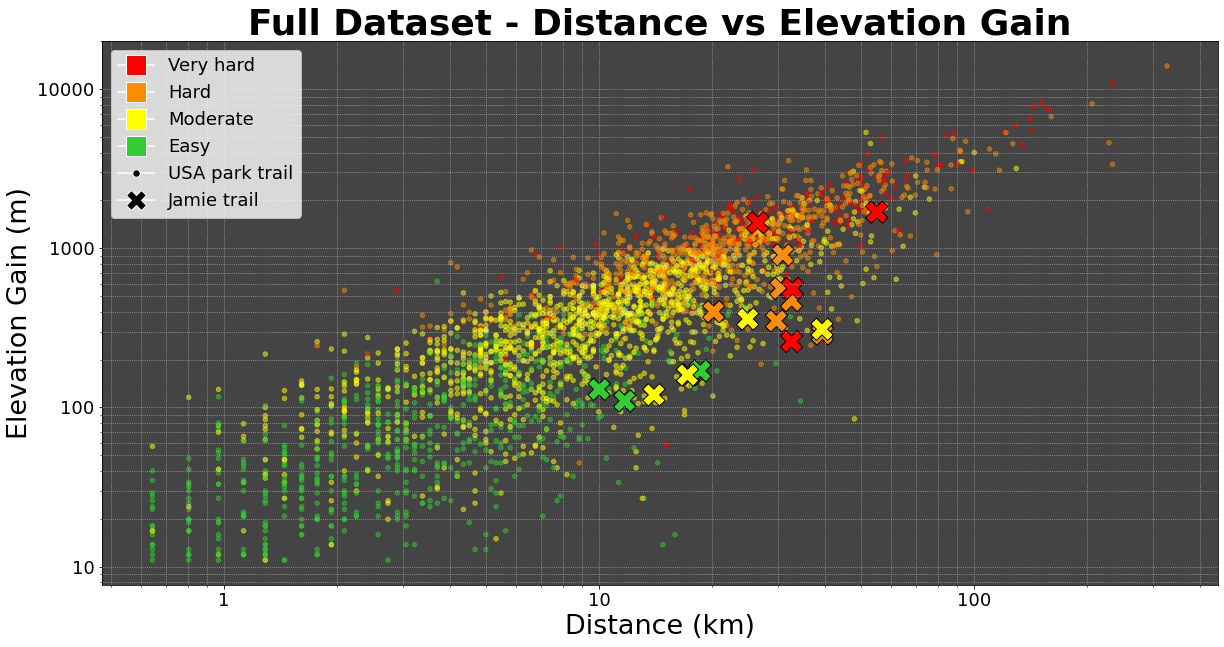

In [14]:
### Full Dataset - Distance vs Elevation Gain (with Difficulty, and Rating)

usaDist = usaTrails.distance
usaGain = usaTrails.elevation_gain
usaDifficulty = difficultyColourIndex(usaTrails)

myDist = myCompletedTrails.distance
myGain = myCompletedTrails.elevation_gain
myDifficulty = difficultyColourIndex(myCompletedTrails)

# plotting
fig = plt.gcf()
ax = plt.gca()
ax.set_title("Full Dataset - Distance vs Elevation Gain", size=titleSize, fontweight='bold')
legend_elements = [
    Line2D([0], [0], marker='s', color=legendColor, label="Very hard", markerfacecolor=diffColors[3], markersize=20),
    Line2D([0], [0], marker='s', color=legendColor, label="Hard", markerfacecolor=diffColors[2], markersize=20),
    Line2D([0], [0], marker='s', color=legendColor, label="Moderate", markerfacecolor=diffColors[1], markersize=20),
    Line2D([0], [0], marker='s', color=legendColor, label="Easy", markerfacecolor=diffColors[0], markersize=20),
    Line2D([0], [0], marker='.', color=legendColor, label="USA park trail", markerfacecolor='k', markersize=15),
    Line2D([0], [0], marker='X', color=legendColor, label="Jamie trail", markerfacecolor='k', markersize=20)]
ax.legend(handles=legend_elements, facecolor=legendColor, prop={'size': legendTextSize})
plt.scatter(usaDist, usaGain, s=20, c=diffColors[usaDifficulty], marker='o', alpha=0.5)
plt.scatter(myDist, myGain, s=500, c=diffColors[myDifficulty], marker='X', edgecolors='k')
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.rcParams['axes.facecolor'] = backgroundColor
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Distance (km)", size=axisLabelSize)
plt.ylabel("Elevation Gain (m)", size=axisLabelSize)
plt.grid(axis="both", which="both", linestyle= 'dotted')
ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.show()

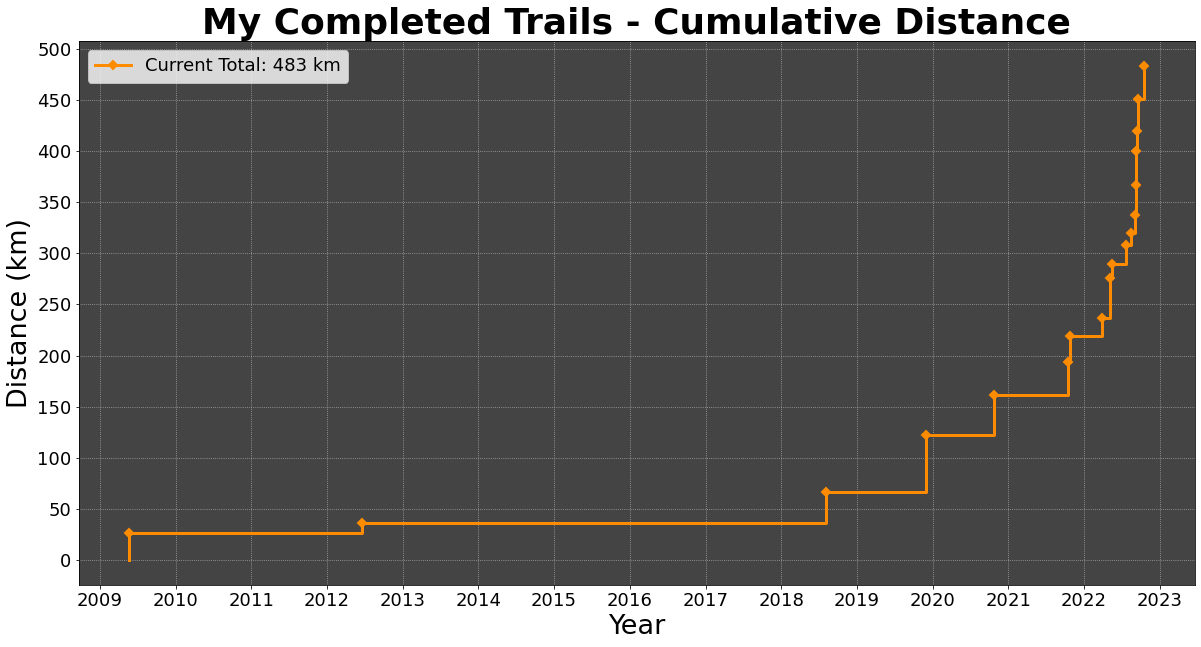

In [15]:
### My Completed Trails - Cumulative Distance

# adding an extra datapoint for step plot appearance
distCum = pd.concat([pd.Series(0), myCompletedTrails.distance.cumsum()])
gainCum = pd.concat([pd.Series(0), myCompletedTrails.elevation_gain.cumsum()])
daysCum = pd.concat([pd.Series(0), myCompletedTrails.nights.cumsum()])
trailCum = np.arange(0, len(myCompletedTrails)+1)
xDates = pd.concat([pd.Series(myCompletedTrails.end_date[0]), myCompletedTrails.end_date])

# plotting
ax = plt.gca()
fig = plt.gcf()
ax.set_title("My Completed Trails - Cumulative Distance", size=titleSize, fontweight="bold")
plt.step(xDates, distCum, where="post", linewidth=3, markevery=(1, 1), marker="D", 
         mew=2, color=distColor, label=f"Current Total: {round(myCompletedTrails.distance.sum())} km")
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.rcParams['axes.facecolor'] = backgroundColor
plt.grid(axis="both", which="both", linestyle= 'dotted')
ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
plt.legend(facecolor=legendColor, prop={'size': legendTextSize})
plt.locator_params(axis='y', nbins=11)
plt.xlabel("Year", size=axisLabelSize)
plt.ylabel("Distance (km)", size=axisLabelSize)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

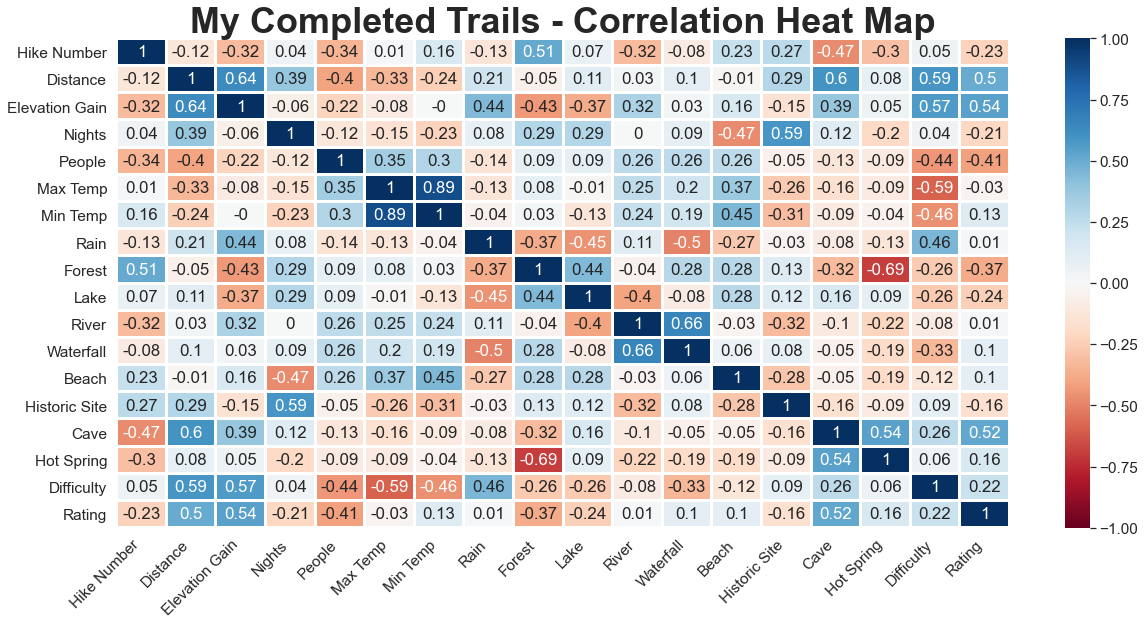

In [17]:
### My Completed Trails - Correlation Heat Map

# generates correlation heat map for the given columns
def corrHeatMap(titleStart, trails, columns, labels):
    trails = trails[columns]
    corr = trails.corr().round(2)
    sns.set(rc={"figure.figsize":(standardCanvasWidth, standardCanvasHeight*0.9)})
    sns.set(font_scale = 1.4)
    heatmap = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center= 0, cmap="RdBu", linewidths=2, yticklabels=labels)
    ax = plt.gca()
    ax.set_xticklabels(labels, rotation = 45, ha="right")
    ax.set_title(f"{titleStart} - Correlation Heat Map", size=titleSize, fontweight="bold")
    plt.show()

myHeatMapColumns = ['id','distance','elevation_gain','nights','people','max_temp','min_temp','rain','forest',
                    'lake','river','waterfall','beach','historic_site','cave','hot_spring','difficulty','rating']

myHeatMapLabels = ['Hike Number','Distance','Elevation Gain','Nights','People','Max Temp','Min Temp','Rain','Forest',
                   'Lake','River','Waterfall','Beach','Historic Site','Cave','Hot Spring','Difficulty','Rating']

corrHeatMap('My Completed Trails', myCompletedTrails, myHeatMapColumns, myHeatMapLabels)

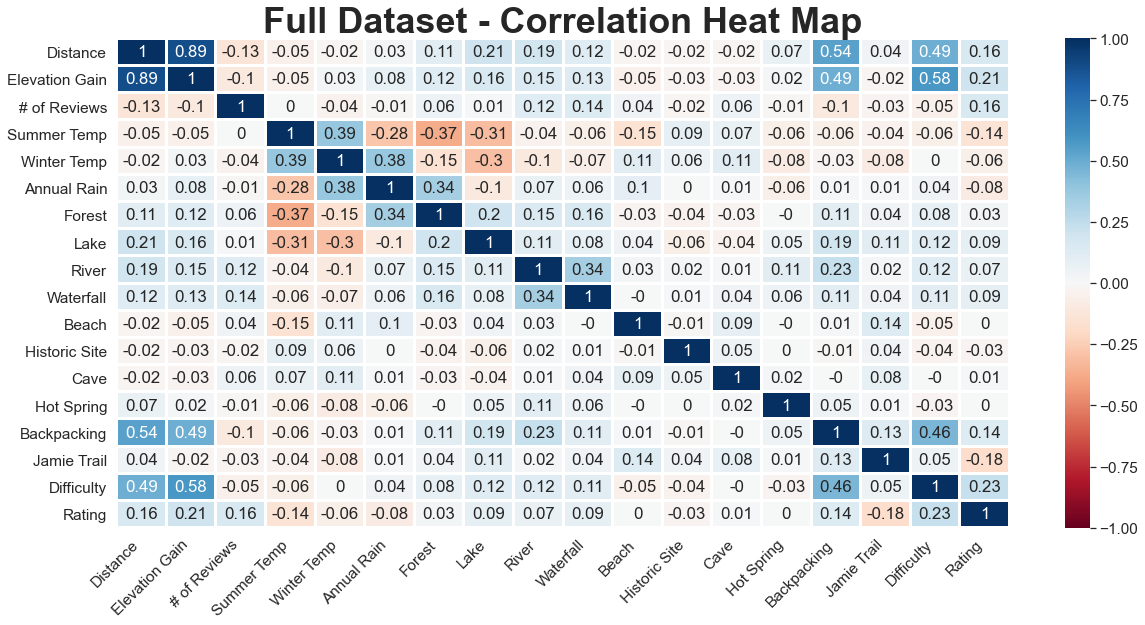

In [18]:
### Full Dataset - Correlation Heat Map

ourHeatMapColumns = ['distance','elevation_gain','num_reviews','summer_temp','winter_temp','annual_rain',
                     'forest','lake','river','waterfall','beach','historic_site','cave','hot_spring',
                     'backpacking','is_jamie','difficulty','rating']

ourHeatMapLabels = ['Distance','Elevation Gain','# of Reviews','Summer Temp','Winter Temp','Annual Rain','Forest',
                    'Lake','River','Waterfall','Beach','Historic Site','Cave','Hot Spring','Backpacking',
                    'Jamie Trail','Difficulty','Rating']

corrHeatMap('Full Dataset', ourTrails, ourHeatMapColumns, ourHeatMapLabels)

In [24]:
### Trail Locations on Map

fig = go.Figure(data=go.Densitymapbox(lon = myCompletedTrails['lng'], lat = myCompletedTrails['lat'], radius=20))

# only uncomment 1 of the next 2 lines; 1st is for my completed trails, 2nd is for the full dataset
# fig = px.density_mapbox(myCompletedTrails, lat='lat', lon='lng', radius=20, center=dict(lat=45.5, lon=276.5), 
#                         zoom=4.8, mapbox_style="stamen-toner")
fig = px.density_mapbox(ourTrails, lat='lat', lon='lng', radius=10, center=dict(lat=40, lon=264), zoom=3.2, 
                        mapbox_style="stamen-toner")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<b><font size="3">Generating Difficulty Model and Predictions</font></b>

In [31]:
### Finding Best Difficulty Estimator

# returns the score for a given model
def testEstimator(model, modelStr, XTrain, yTrain, XTest, yTest):
    model.fit(XTrain, yTrain)
    print(f'{modelStr}: {round(model.score(XTest, yTest), 2)}')

# setting up data for training
y_difficulty = ourTrails.loc[:, 'difficulty']
X_columns = ['park', 'province', 'country', 'distance', 'elevation_gain', 'route_type', 'num_reviews', 
             'summer_temp', 'winter_temp', 'annual_rain', 'forest', 'lake', 'river', 'waterfall', 'beach', 
             'historic_site', 'cave', 'hot_spring', 'backpacking', 'is_jamie']
ourTrailsForTraining = ourTrails[X_columns]
ourTrailsForTraining = transformer.fit_transform(ourTrailsForTraining)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(ourTrailsForTraining, y_difficulty, test_size=0.2)

print('DIFFICULTY MODEL SCORES:') # Can treat difficulty as numeric or catagorical
testEstimator(Ridge(), 'Ridge', X_train_d, y_train_d, X_test_d, y_test_d)
testEstimator(SVR(), 'SVR', X_train_d, y_train_d, X_test_d, y_test_d)
testEstimator(Lasso(), 'Lasso', X_train_d, y_train_d, X_test_d, y_test_d)
testEstimator(SVC(kernel='rbf'), 'SVC', X_train_d, y_train_d, X_test_d, y_test_d)
testEstimator(RandomForestClassifier(), 'Random Forest Classifier', X_train_d, y_train_d, X_test_d, y_test_d)

DIFFICULTY MODEL SCORES:
Ridge: 0.37
SVR: 0.55
Lasso: 0.37
SVC: 0.68
Random Forest Classifier: 0.7


In [ ]:
### Creating Difficulty Model - if SVC is best

# cvGridSVC = {'C': [0.1, 1, 10, 100, 1000], 
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#              'kernel': ['rbf']} 

# difficutyModel = GridSearchCV(SVC(kernel='rbf'), cvGridSVC, refit=True, verbose=0)
# difficutyModel.fit(X_train_d, y_train_d)
# difficultyScore = round(difficutyModel.score(X_test_d, y_test_d), 3)
# difficultyModelFileName = f"trailGenie_difficulty_{difficultyScore}.sav"
# # saving best difficulty model
# pickle.dump(difficutyModel, open(difficultyModelFileName, 'wb'))

# print(f'Difficulty Model Score: {difficultyScore}')

In [33]:
### Creating Difficulty Model - if Random Forest Classifier is best

cvGridRFC = {"n_estimators": [100, 250, 500],
             "max_depth": [5, 10, 20],
             "min_samples_split": [2, 4, 8],
             "min_samples_leaf": [1, 2, 4]}

difficutyModel = GridSearchCV(RandomForestClassifier(), cvGridRFC, refit=True, verbose=0)
difficutyModel.fit(X_train_d, y_train_d)
difficultyScore = round(difficutyModel.score(X_test_d, y_test_d), 3)
difficultyModelFileName = f"trailGenie_difficulty_{difficultyScore}.sav"
# saving best difficulty model
pickle.dump(difficutyModel, open(difficultyModelFileName, 'wb'))

print(f'Difficulty Model Score: {difficultyScore}')

Difficulty Model Score: 0.705


In [155]:
### Making Difficulty Predictions

# loading difficulty model
# difficutyModel = pickle.load(open("trailGenie_difficulty_0.???.sav", 'rb')) # replace ??? with numbers on file name
difficutyModel = pickle.load(open(difficultyModelFileName, 'rb'))

# setting up data for predictions
myWatchedTrailsForPrediction = myWatchedTrails[X_columns]
myWatchedTrailsForPrediction = transformer.fit_transform(myWatchedTrailsForPrediction)

difficutyModelWeightedScores = []
for row in difficutyModel.predict_proba(myWatchedTrailsForPrediction):
    # getting the weighted average of the difficulty predictions
    difficutyModelWeightedScores.append(round((row[0])+(3*row[1])+(5*row[2])+(7*row[3]), 2)) 

# adding weighted averages to myWatchedTrails
myWatchedTrails.difficulty = difficutyModelWeightedScores

<b><font size="3">Generating Rating Model and Predictions</font></b>

In [132]:
### Finding Best Rating Estimator

# setting up data for training
y_rating = ourTrails.loc[:, 'rating']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(ourTrailsForTraining, y_rating, test_size=0.2)

print('RATING MODEL SCORES:')
testEstimator(Ridge(), 'Ridge', X_train_r, y_train_r, X_test_r, y_test_r)
testEstimator(SVR(), 'SVR', X_train_r, y_train_r, X_test_r, y_test_r)
testEstimator(Lasso(), 'Lasso', X_train_r, y_train_r, X_test_r, y_test_r)

FUN MODEL SCORES:
Ridge: 0.15
SVR: 0.13
Lasso: 0.09


In [136]:
### Creating Rating Model

ratingModel = RidgeCV()
ratingModel.fit(X_train_r, y_train_r)
ratingScore = round(ratingModel.score(X_test_r, y_test_r), 3)
ratingModelFileName = f"trailGenie_rating_{ratingScore}.sav"
# saving best rating model
pickle.dump(ratingModel, open(ratingModelFileName, 'wb'))

print(f'Rating Model Score: {ratingScore}')

Rating Model Score: 0.222


In [150]:
### Making Rating Predictions

# loading difficulty model
# ratingModel = pickle.load(open("trailGenie_rating_0.???.sav", 'rb'))  # replace ??? with numbers on file name
ratingModel = pickle.load(open(ratingModelFileName, 'rb'))    

# adding prediction results to myWatchedTrails
myWatchedTrails.rating = np.round(ratingModel.predict(myWatchedTrailsForPrediction), 2)

In [151]:
### Saving Prediction Results

# setting up a new myTrails with predictions results and only the original columns
myTrails = pd.concat([myCompletedTrails, myWatchedTrails])[['name', 'id', 'status', 'park', 'province',
    'country', 'distance', 'elevation_gain', 'start_date', 'end_date', 'nights', 'people', 'max_temp', 'min_temp', 
    'rain', 'summer_temp', 'winter_temp', 'annual_rain', 'route_type', 'lat', 'lng', 'forest', 'lake', 'river',
    'waterfall', 'beach', 'historic_site', 'cave', 'hot_spring', 'difficulty', 'rating', 'route1', 'route2']]

# saving
myTrails.to_csv(myTrailsCSV, index=False)

<b><font size="3">Plotting Difficulty and Rating Prediction Results</font></b>

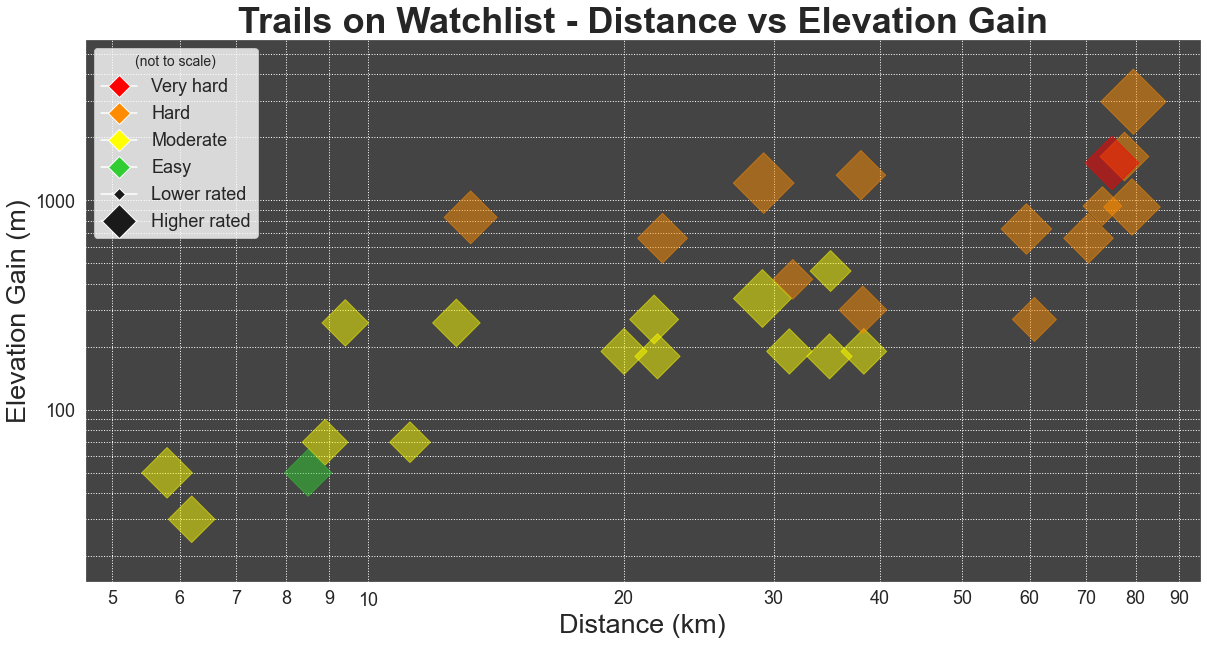

In [190]:
### Trails on Watchlist (with Prediction Results) - Distance vs Elevation Gain (with Difficulty, and Rating)

# generating Distance vs Elevation Gain plot for the trails on my watchlist
distWatch = myWatchedTrails.distance
gainWatch = myWatchedTrails.elevation_gain
ratingWatch = ratingSize(myWatchedTrails.rating)
diffWatch = []
for hikeDifficulty in difficutyModel.predict(myWatchedTrailsForPrediction):
    if hikeDifficulty == 1:
        diffWatch.append(0)
    elif hikeDifficulty == 3:
        diffWatch.append(1)
    elif hikeDifficulty == 5:
        diffWatch.append(2)
    elif hikeDifficulty == 7:
        diffWatch.append(3)

distGainPlot('Trails on Watchlist', distWatch, gainWatch, ratingWatch, diffWatch)